## Credit Card Fraud Analysis

### Import the libraries from sklearn and imblearn

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import collections
from collections import Counter
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from pprint import pprint
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_context('notebook')
sns.set_style(style='darkgrid')
%matplotlib inline
classificationReportDict = {}

### Define common routines

In [2]:
def get_roc(y_test, y_pred):
    #Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics')
    plt.legend(loc='upper left')
    plt.show()
    return

#This displays a sample confusion matrix and ROC
def analyzePredictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    #------------------------------
    drawConfusionMatrix(cnf_matrix)
    #-----------------------------------------
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    #------------------------------------------
    y_pred_proba = model.predict_proba(X_test)[:,1]
    get_roc(y_test, y_pred_proba)
    
def drawConfusionMatrix(cnf_matrix):
    print(cnf_matrix)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
def printScores(model, X_train, X_test, y_train, y_test):
    y_predict_test = model.predict(X_test)
    y_predict_training = model.predict(X_train)
    print("[Training Classification Report]")
    #print(classification_report(y_train, y_predict_training))
    print("Precision = ", precision_score(y_train, y_predict_training))
    print("Recall = ", recall_score(y_train, y_predict_training))
    print("F1 Score = ", f1_score(y_train, y_predict_training))

    print("")
    print("[Test Classification Report]")
    #print(classification_report(y_test, y_predict_test))
    print("Precision = ", precision_score(y_test, y_predict_test))
    print("Recall = ", recall_score(y_test, y_predict_test))
    print("F1 Score = ", f1_score(y_test, y_predict_test))
    return

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()
    
def printClassificationReport(model, X_train, X_test, y_train, y_test):
    return 
    
def runLogisticRegression(X_train, y_train, X_test, y_test, iter=500, c=10):
    model = LogisticRegression(solver='lbfgs', max_iter=iter, C=c).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    drawConfusionMatrix(confusion_matrix(y_test, y_pred))    
    y_pred_proba = model.predict_proba(X_test)[:,1]
    get_roc(y_test, y_pred_proba)
    print ("Training Classification Report")
    print (classification_report(y_train, model.predict(X_train)))
    print ("Test Classification Report")
    print (classification_report(y_test, model.predict(X_test))) 
    classificationReport = classification_report(y_train, model.predict(X_train), output_dict = True), classification_report(y_test, model.predict(X_test), output_dict = True)  
    return model, classificationReport


### Read the credit card fraud data

In [3]:
data = pd.read_csv('C:\\Harinee\\Capstone1\\creditcardfraud\\creditcard.csv')
data.head(10)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [4]:
print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


(1) When doing the train/test split, it would be important
to preserver the proportion among the classes in
both sets.

### Split the data to train and test

In [5]:
X = data.drop('Class', axis=1)
y = data['Class']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123, shuffle=True)
print ("Training Data")
print('No Frauds', round(y_train.value_counts()[0]/len(y_train) * 100,2), '% of the dataset -- ', round(y_train.value_counts()[0]), "of", len(y_train))
print('Frauds', round(y_train.value_counts()[1]/len(y_train) * 100,2), '% of the dataset -- ', round(y_train.value_counts()[1]), "of", len(y_train))
print ("Test Data")
print('No Frauds', round(y_test.value_counts()[0]/len(y_test) * 100,2), '% of the dataset -- ', round(y_test.value_counts()[0]), "of", len(y_test))
print('Frauds', round(y_test.value_counts()[1]/len(y_test) * 100,2), '% of the dataset -- ', round(y_test.value_counts()[1]), "of", len(y_test))

Training Data
No Frauds 99.83 % of the dataset --  227451 of 227845
Frauds 0.17 % of the dataset --  394 of 227845
Test Data
No Frauds 99.83 % of the dataset --  56864 of 56962
Frauds 0.17 % of the dataset --  98 of 56962


did the proportion is reflected in the split of 80 and 20

### Run logistic regression

Logistic Regression
[[56852    12]
 [   39    59]]


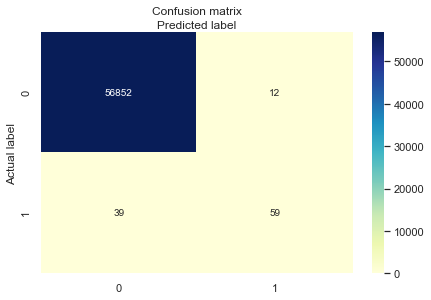

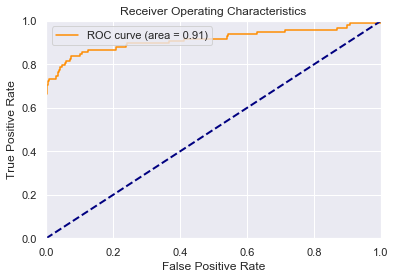

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.85      0.64      0.73       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.92      0.82      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.60      0.70        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



In [6]:
#Logistic Regression
#Use Logistic Regression using the train data, then compute the confusion matrix and the AUC.
print ("Logistic Regression")
model, classificationReport = runLogisticRegression(X_train, y_train, X_test, y_test)
classificationReportDict["Initial Run"] = classificationReport

The Model is NOT overfitting. Still run Logistic Regression With A L1 Penalty With Various Regularization Strengths The usefulness of L1 is that it can push feature coefficients to 0, creating a method for feature selection. In the code below we run a logistic regression with a L1 penalty four times, each time decreasing the value of C. We should expect that as C decreases, more coefficients become 0.

### Try with different learning rates C - L1 penalty

In [7]:
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train, y_train))
    print('Test accuracy:', clf.score(X_test, y_test))
    print('')

C: 10
Coefficient of each feature: [[-4.17258305e-06  8.23825441e-02 -2.74603451e-02 -2.81565273e-02
   6.49989379e-01  1.13549523e-01 -1.00048199e-01 -8.49216257e-02
  -1.71785762e-01 -3.61823793e-01 -8.11887247e-01 -5.92052625e-02
   3.38113553e-02 -2.80268291e-01 -5.61329073e-01 -1.21115370e-01
  -1.20569946e-01 -5.00745537e-02 -8.90421091e-03  1.16185210e-01
  -4.24926590e-01  4.20085612e-01  6.43657076e-01 -4.42813613e-02
   2.36204264e-01 -2.00642346e-01  5.09785456e-02 -8.24712640e-01
  -2.92546198e-01  6.62201984e-04]]
Training accuracy: 0.9992582676819768
Test accuracy: 0.9991397773954567

C: 1
Coefficient of each feature: [[-3.47857512e-06  7.27659466e-02 -1.94242943e-02 -1.00993052e-02
   6.39931792e-01  1.08712971e-01 -9.73698068e-02 -8.87826729e-02
  -1.68844020e-01 -3.41408256e-01 -7.89613622e-01 -3.60927665e-02
   9.29798609e-03 -2.63760253e-01 -5.53530085e-01 -1.06935349e-01
  -1.20094287e-01 -4.29646832e-02 -9.00542824e-03  1.04958106e-01
  -4.09596427e-01  4.01645993e

### Try with different learning rates C - L2 penalty

In [8]:
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l2', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train, y_train))
    print('Test accuracy:', clf.score(X_test, y_test))
    print('')

C: 10
Coefficient of each feature: [[-8.94549492e-05  1.97945300e-01 -3.64664126e-01 -8.61960105e-01
   1.58735680e-01 -5.14909084e-02 -7.35502988e-02  9.86330941e-02
  -1.83581205e-01 -4.10982500e-01 -2.45477956e-01 -1.61185372e-01
  -6.15540679e-02 -2.69335138e-01 -7.85484105e-01 -2.71710949e-01
  -3.08136772e-01 -5.24778367e-01 -1.64287697e-02  6.07515605e-02
   6.17315951e-02  1.80028133e-01  2.27952593e-01  4.39481219e-02
  -2.99681458e-02 -2.06601237e-01  3.58380569e-02 -6.03006269e-02
   3.86275464e-02 -7.13067795e-03]]
Training accuracy: 0.999065153942373
Test accuracy: 0.9989642217618764

C: 1
Coefficient of each feature: [[-8.94481317e-05  1.97857344e-01 -3.64574314e-01 -8.61712755e-01
   1.58700484e-01 -5.14609242e-02 -7.35311976e-02  9.86447918e-02
  -1.83550551e-01 -4.10825002e-01 -2.45395599e-01 -1.61130396e-01
  -6.15682961e-02 -2.69228594e-01 -7.85234636e-01 -2.71654640e-01
  -3.08031107e-01 -5.24579907e-01 -1.64030885e-02  6.07253278e-02
   6.17099745e-02  1.79975582e-

So, Now number of coefficients with zero values is zero. So, now it is clear that Ridge regularisation (L2 Regularisation) does not shrink the coefficients to zero.

### Print Classification Report

The classification report metrics are similar in training and Test and it is too good to be true. The reason being due to the imbalanced data set and hence it needs to be addressed.

### Drop one variable at a time and run the model, to test for accuracy and precision and recall

Dropping  Time


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[[56855     9]
 [   42    56]]


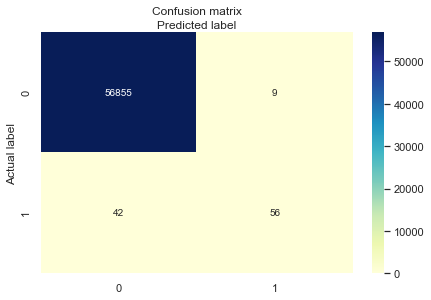

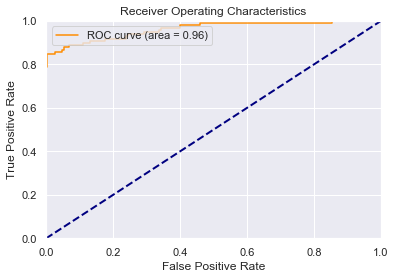

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.90      0.64      0.75       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.95      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.57      0.69        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.93      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V1
[[56846    18]
 [   41    57]]


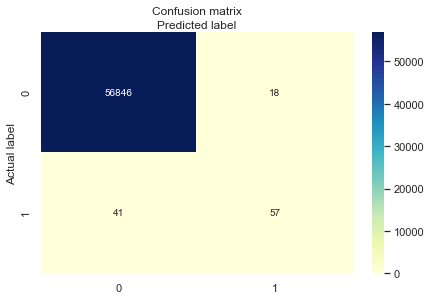

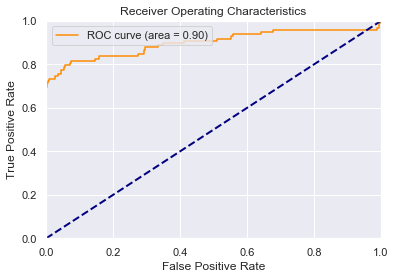

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.85      0.64      0.73       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.92      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.58      0.66        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.88      0.79      0.83     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V2
[[56851    13]
 [   39    59]]


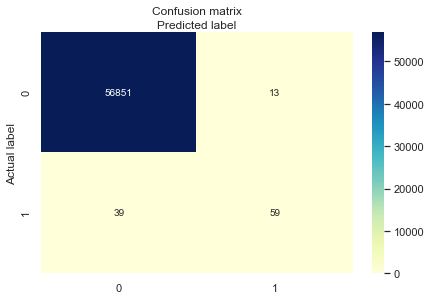

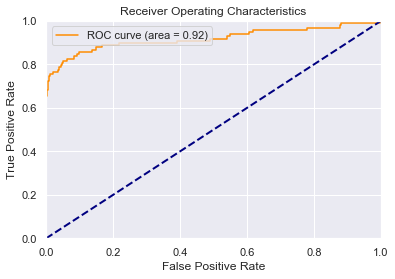

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.82      0.63      0.71       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.91      0.82      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.60      0.69        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.91      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V3
[[56854    10]
 [   41    57]]


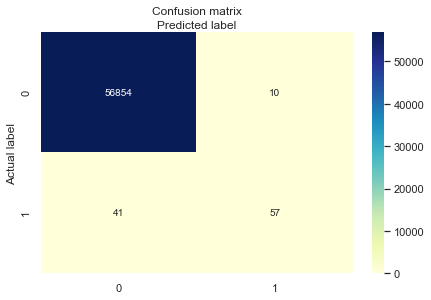

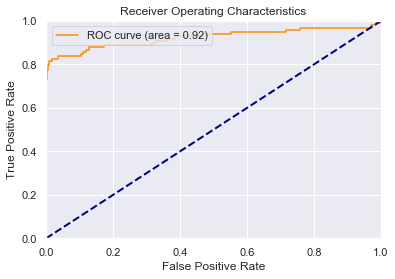

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.87      0.66      0.76       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.94      0.83      0.88    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.58      0.69        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V4
[[56851    13]
 [   39    59]]


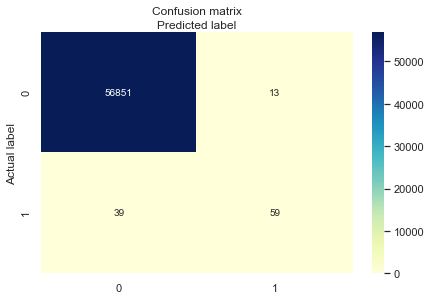

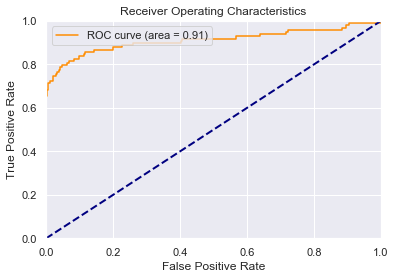

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.84      0.63      0.72       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.92      0.82      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.60      0.69        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.91      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V5
[[56853    11]
 [   41    57]]


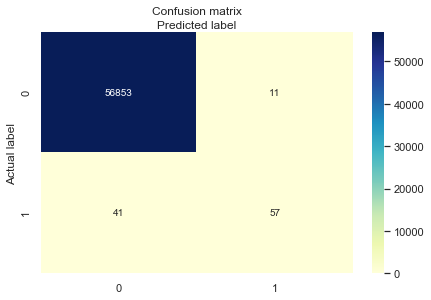

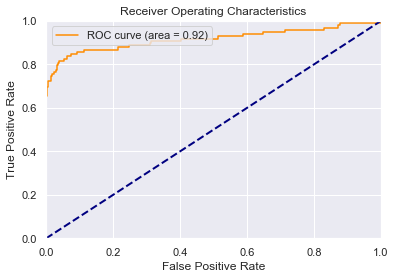

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.84      0.64      0.72       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.92      0.82      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.58      0.69        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V6
[[56852    12]
 [   39    59]]


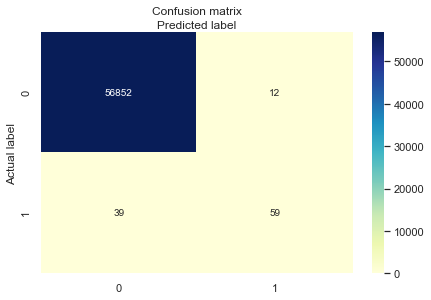

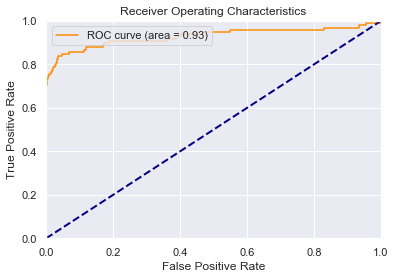

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.87      0.68      0.76       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.94      0.84      0.88    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.60      0.70        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V7
[[56856     8]
 [   40    58]]


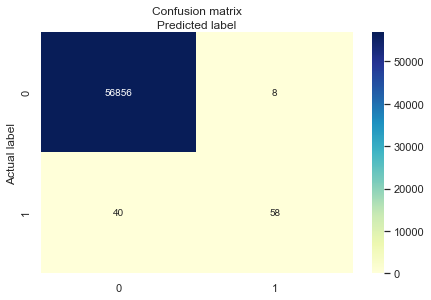

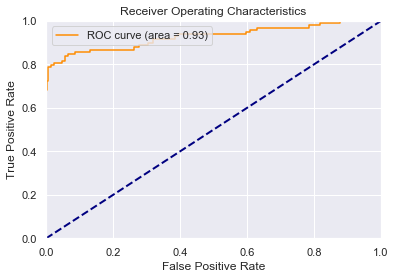

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.85      0.66      0.75       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.93      0.83      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.59      0.71        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.94      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V8
[[56854    10]
 [   41    57]]


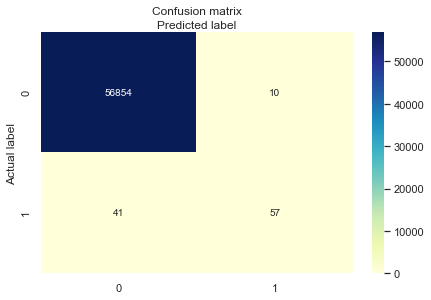

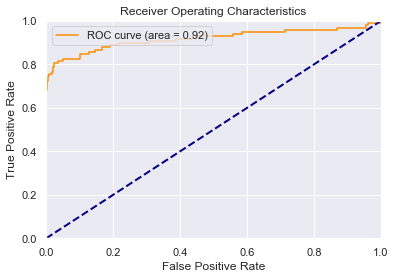

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.87      0.66      0.75       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.93      0.83      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.58      0.69        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V9


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[[56854    10]
 [   42    56]]


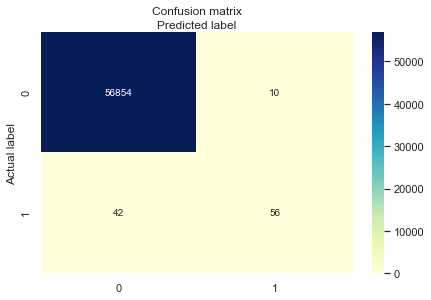

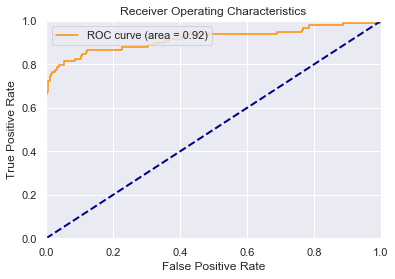

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.84      0.62      0.71       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.92      0.81      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.57      0.68        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V10
[[56853    11]
 [   42    56]]


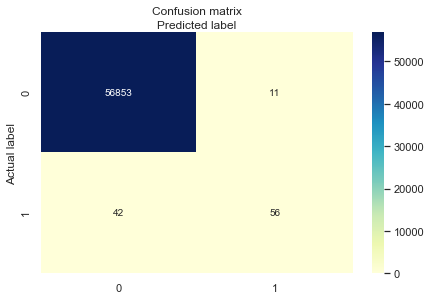

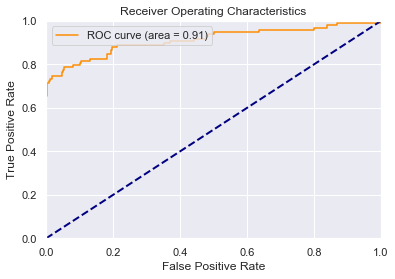

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.84      0.63      0.72       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.92      0.81      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.57      0.68        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V11
[[56850    14]
 [   38    60]]


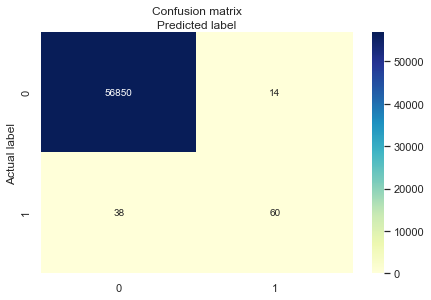

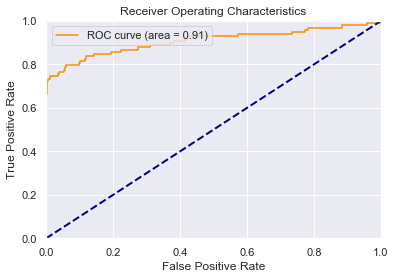

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.85      0.65      0.74       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.92      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.61      0.70        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.91      0.81      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V12
[[56851    13]
 [   41    57]]


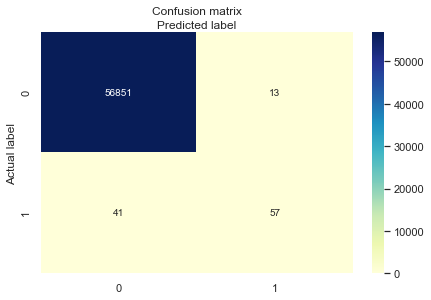

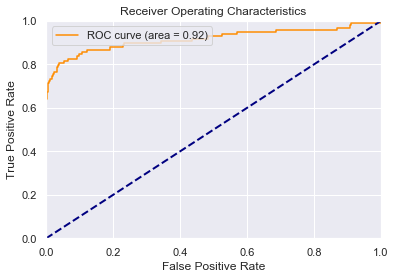

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.83      0.61      0.70       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.91      0.81      0.85    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.58      0.68        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.91      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V13
[[56850    14]
 [   39    59]]


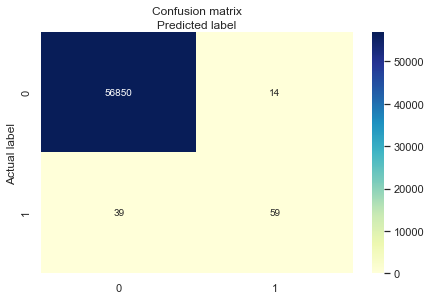

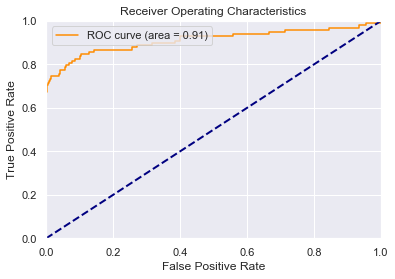

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.86      0.64      0.74       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.93      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.60      0.69        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.90      0.80      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V14


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[[56851    13]
 [   42    56]]


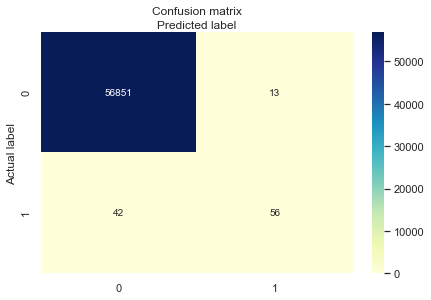

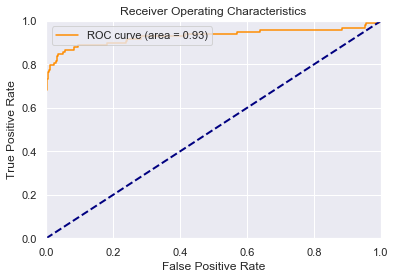

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.87      0.64      0.73       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.93      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.57      0.67        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.91      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V15
[[56854    10]
 [   38    60]]


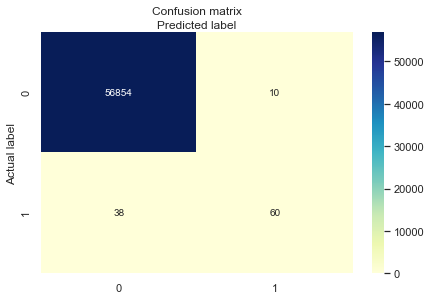

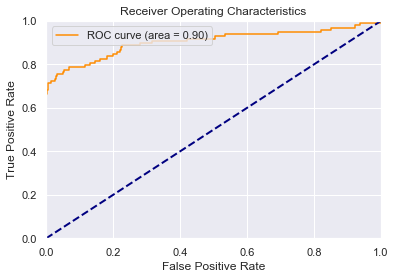

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.86      0.64      0.74       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.93      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.61      0.71        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.93      0.81      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V16
[[56849    15]
 [   38    60]]


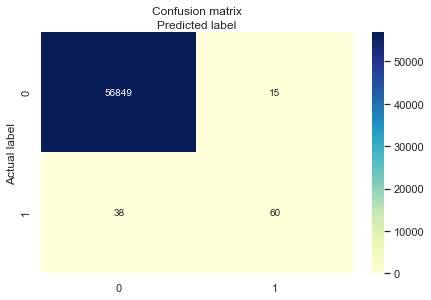

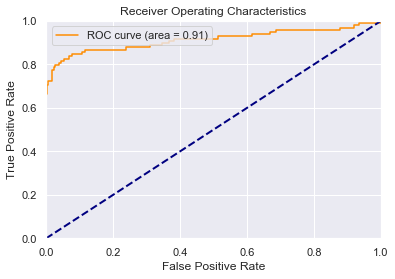

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.83      0.65      0.73       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.91      0.83      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.61      0.69        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.90      0.81      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V17
[[56851    13]
 [   40    58]]


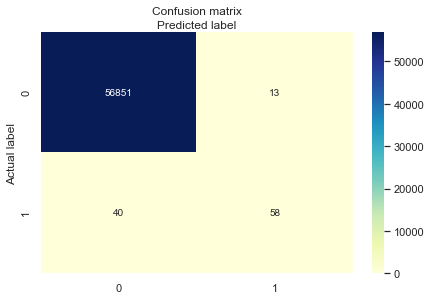

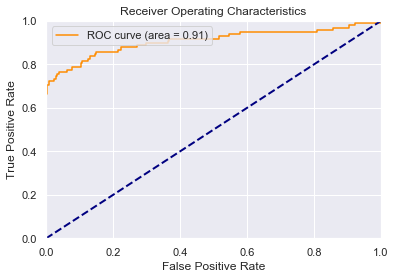

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.86      0.65      0.74       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.93      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.59      0.69        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.91      0.80      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V18
[[56851    13]
 [   41    57]]


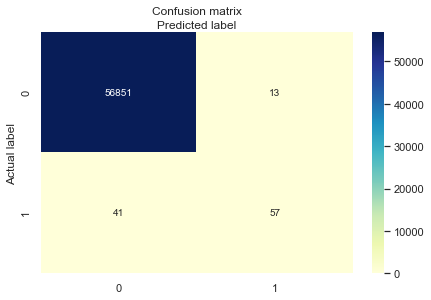

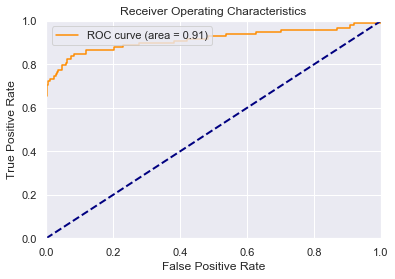

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.84      0.63      0.72       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.92      0.81      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.58      0.68        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.91      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V19
[[56852    12]
 [   39    59]]


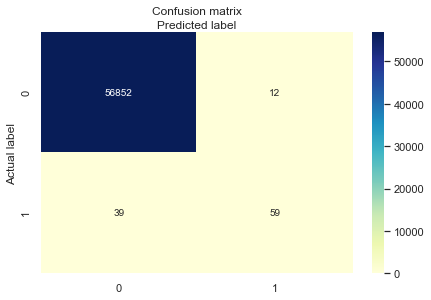

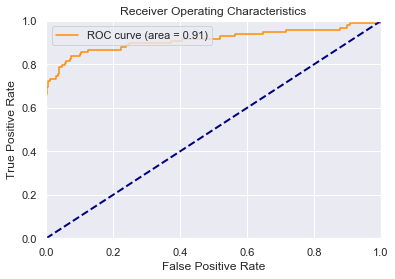

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.85      0.64      0.73       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.92      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.60      0.70        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V20


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[[56854    10]
 [   42    56]]


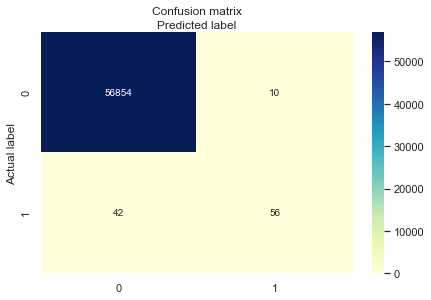

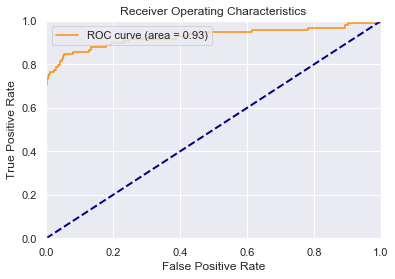

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.86      0.66      0.74       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.93      0.83      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.57      0.68        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V21
[[56852    12]
 [   38    60]]


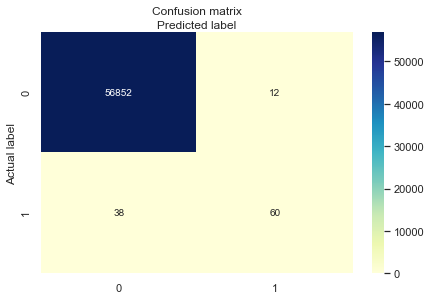

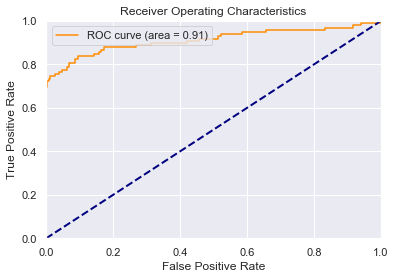

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.85      0.64      0.73       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.93      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.61      0.71        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.81      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V22
[[56851    13]
 [   41    57]]


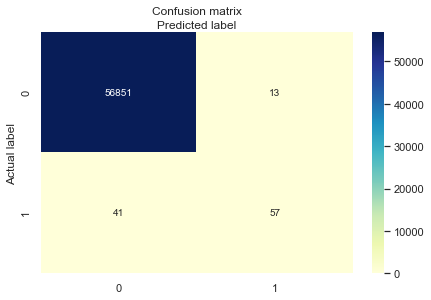

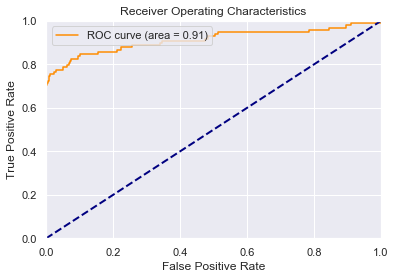

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.87      0.67      0.76       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.93      0.84      0.88    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.58      0.68        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.91      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V23
[[56850    14]
 [   38    60]]


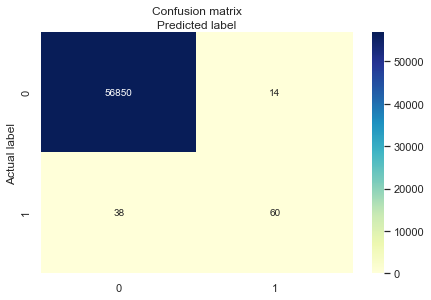

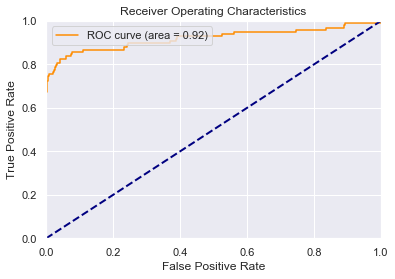

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.83      0.68      0.75       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.92      0.84      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.61      0.70        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.91      0.81      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V24
[[56852    12]
 [   39    59]]


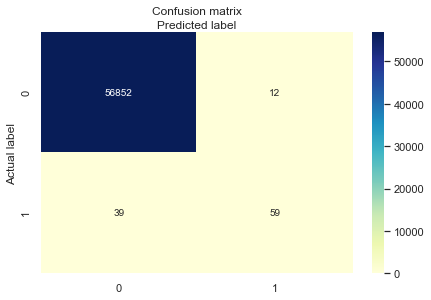

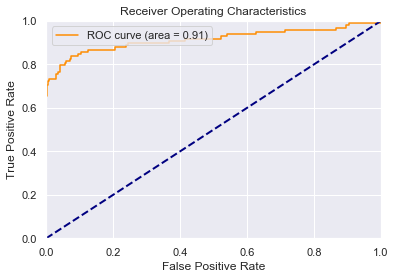

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.85      0.64      0.73       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.92      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.60      0.70        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V25
[[56848    16]
 [   37    61]]


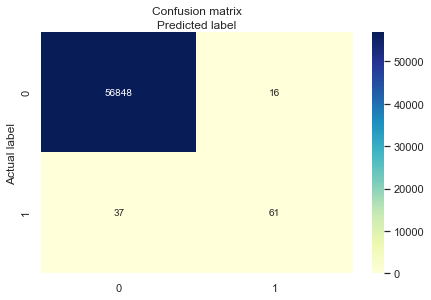

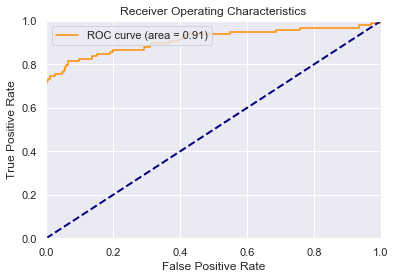

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.86      0.67      0.75       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.93      0.84      0.88    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.62      0.70        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.90      0.81      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V26
[[56851    13]
 [   41    57]]


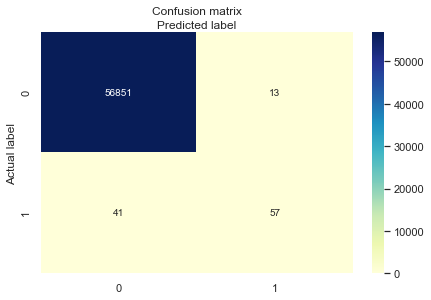

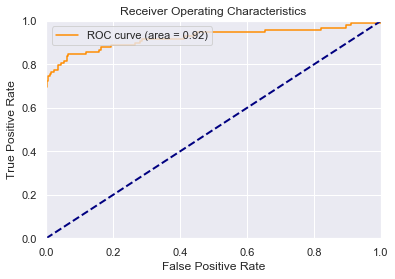

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.86      0.67      0.75       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.93      0.83      0.88    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.58      0.68        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.91      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V27
[[56853    11]
 [   39    59]]


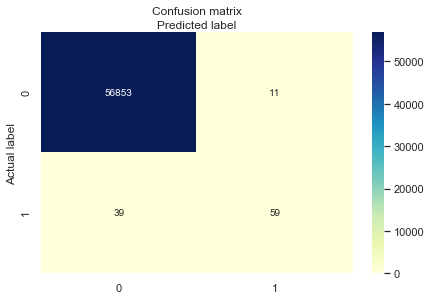

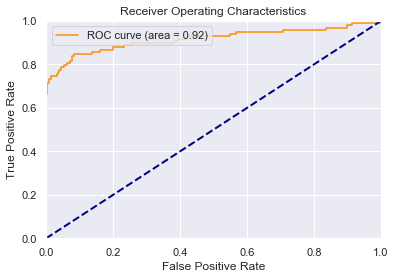

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.86      0.64      0.73       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.93      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.60      0.70        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  V28
[[56853    11]
 [   38    60]]


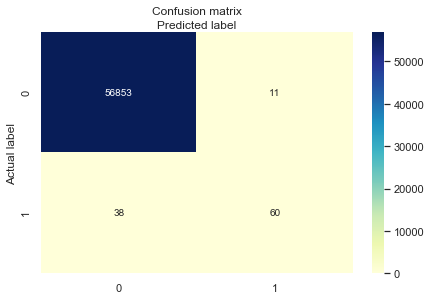

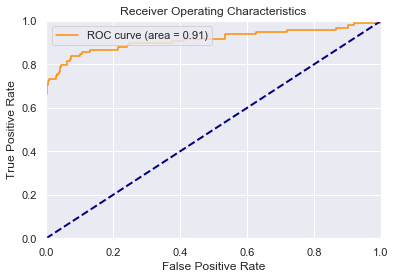

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.85      0.64      0.73       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.92      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.61      0.71        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.81      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Dropping  Amount
[[56852    12]
 [   37    61]]


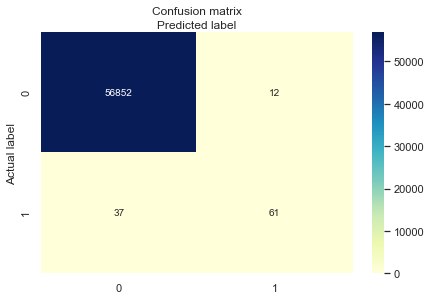

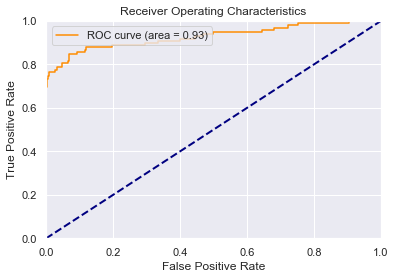

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.88      0.69      0.77       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.94      0.84      0.89    227845
weighted avg       1.00      1.00      1.00    227845

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.62      0.71        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.92      0.81      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [9]:
xAx=[]
accAx=[]
precAx=[]
recAx=[]
f1Ax=[]
for idx, val in enumerate(X_train.columns):
    print("Dropping ", val)
    X_train_new = X_train.drop(val, axis=1)
    X_test_new = X_test.drop(val, axis=1)
    model, classificationReport = runLogisticRegression(X_train_new, y_train, X_test_new, y_test)
    classificationReportDict["Dropping" + val] = classificationReport
    y_predict_training = model.predict(X_train_new)
    xAx = np.append(xAx, val)
    accAx = np.append(accAx, accuracy_score(y_train, y_predict_training))
    precAx = np.append(precAx, precision_score(y_train, y_predict_training))
    recAx = np.append(recAx, recall_score(y_train, y_predict_training))
    f1Ax = np.append(f1Ax, f1_score(y_train, y_predict_training))


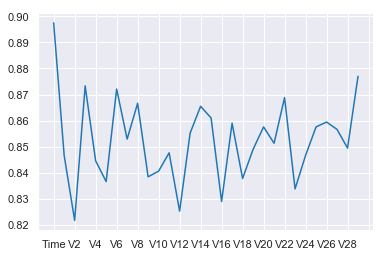

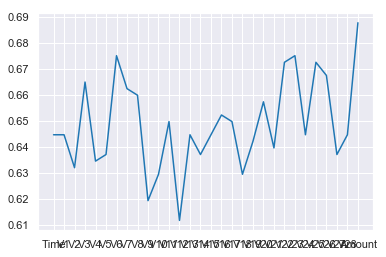

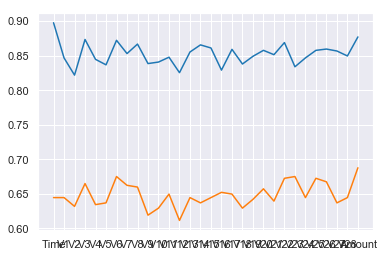

In [10]:
plt.xticks(list(range(0, 100,2))) 
plt.plot(xAx, precAx)
plt.show()
plt.plot(xAx, recAx)
plt.show()
plt.plot(xAx, precAx, recAx)
plt.show()


### Random Undersampling, get both classes 0, 1 to 492 rows

In [11]:
count_class_0, count_class_1 = y_train.groupby(y_train==1).count()
X_train_data = X_train.join(pd.DataFrame(y_train))
df_class_0 = X_train_data[X_train_data['Class'] == 0]
df_class_1 = X_train_data[X_train_data['Class'] == 1]


Random under-sampling:
(788, 30)
[[55257  1607]
 [   18    80]]


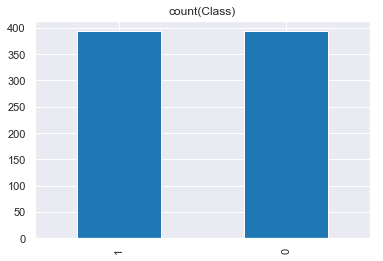

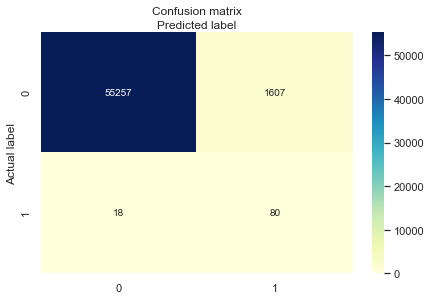

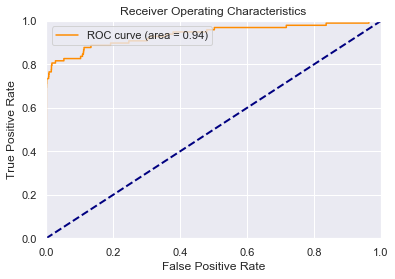

Training Classification Report
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       394
           1       0.97      0.87      0.92       394

   micro avg       0.92      0.92      0.92       788
   macro avg       0.93      0.92      0.92       788
weighted avg       0.93      0.92      0.92       788

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.82      0.09        98

   micro avg       0.97      0.97      0.97     56962
   macro avg       0.52      0.89      0.54     56962
weighted avg       1.00      0.97      0.98     56962



In [12]:
print('Random under-sampling:')
df_class_0_under = df_class_0.sample(count_class_1)
df_data_under = pd.concat([df_class_0_under, df_class_1], axis=0)
#Verify df_data_under has equal number of 0 and 1
df_data_under.Class.value_counts().plot(kind='bar',title = 'count(Class)')
X_train_under = df_data_under.drop('Class', axis=1)
y_train_under = df_data_under['Class']
print (X_train_under.shape)
model,classificationReport = runLogisticRegression(X_train_under, y_train_under, X_test, y_test)
classificationReportDict["Random Undersampling"] = classificationReport

### Random Oversampling, get both classes 0, 1 to 284315 rows


Random over-sampling:
1    227451
0    227451
Name: Class, dtype: int64
(454902, 30)
[[54732  2132]
 [   17    81]]


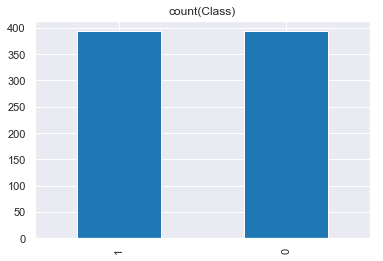

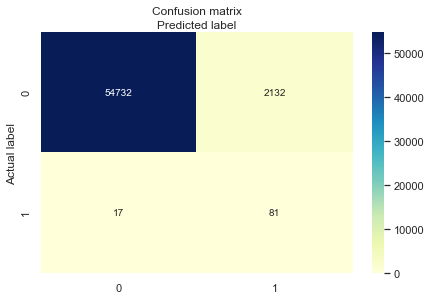

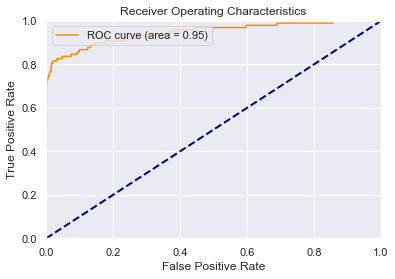

Training Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93    227451
           1       0.96      0.89      0.92    227451

   micro avg       0.93      0.93      0.93    454902
   macro avg       0.93      0.93      0.93    454902
weighted avg       0.93      0.93      0.93    454902

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.83      0.07        98

   micro avg       0.96      0.96      0.96     56962
   macro avg       0.52      0.89      0.53     56962
weighted avg       1.00      0.96      0.98     56962



In [13]:
print('Random over-sampling:')
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_data_over = pd.concat([df_class_0, df_class_1_over], axis=0)
#Verify df_data_over has equal number of 0 and 1
print(df_data_over.Class.value_counts())
df_data_under.Class.value_counts().plot(kind='bar',title = 'count(Class)')
X_train_over = df_data_over.drop('Class', axis=1)
y_train_over = df_data_over['Class']
print (X_train_over.shape)
model,classificationReport = runLogisticRegression(X_train_over, y_train_over, X_test, y_test)
classificationReportDict["Random Oversampling"] = classificationReport

### Imbalanced Learn Undersampling, get both classes 0, 1 to 492 rows


[[54456  2408]
 [   17    81]]


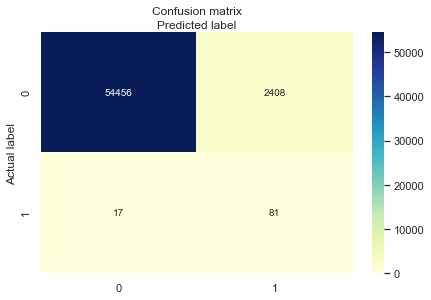

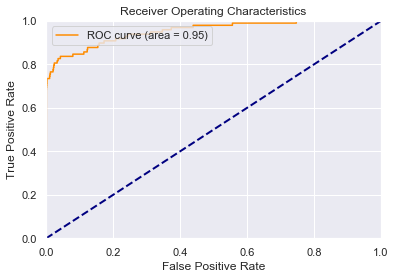

Training Classification Report
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       394
           1       0.96      0.88      0.92       394

   micro avg       0.92      0.92      0.92       788
   macro avg       0.93      0.92      0.92       788
weighted avg       0.93      0.92      0.92       788

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.03      0.83      0.06        98

   micro avg       0.96      0.96      0.96     56962
   macro avg       0.52      0.89      0.52     56962
weighted avg       1.00      0.96      0.98     56962



In [14]:
#IMBLearn Undersampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train,y_train)
model, classificationReport = runLogisticRegression(X_rus, y_rus, X_test, y_test)
classificationReportDict["IMBLearn Undersampling"] = classificationReport

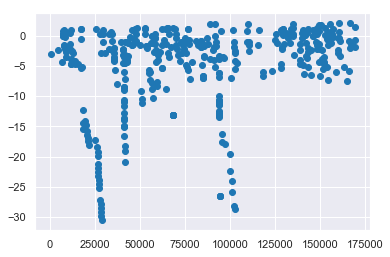

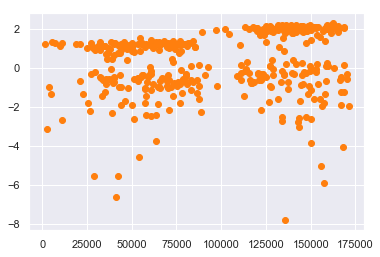

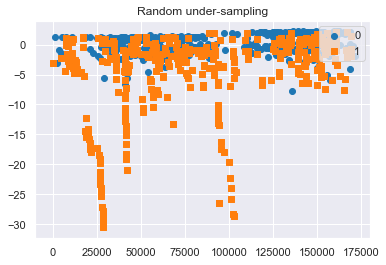

In [15]:
plt.scatter(
            X_rus[y_rus==1, 0],
            X_rus[y_rus==1, 1],
            c='#1F77B4', label=1, marker='o'
        )
plt.show()
plt.scatter(
            X_rus[y_rus==0, 0],
            X_rus[y_rus==0, 1],
            c='#FF7F0E', label=1, marker='o'
        )
plt.show()
plot_2d_space(X_rus, y_rus, 'Random under-sampling')

### Imbalanced Learn Oversampling, get both classes 0, 1 to 284315 rows

[[54714  2150]
 [   17    81]]


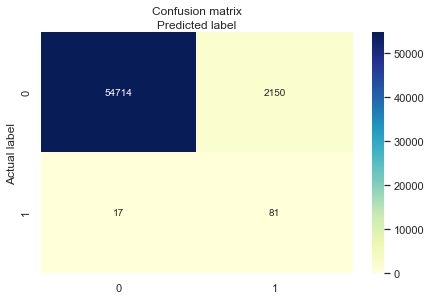

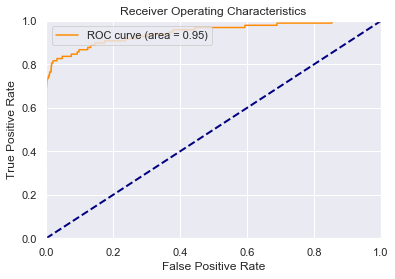

Training Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93    227451
           1       0.96      0.89      0.92    227451

   micro avg       0.93      0.93      0.93    454902
   macro avg       0.93      0.93      0.93    454902
weighted avg       0.93      0.93      0.93    454902

Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.83      0.07        98

   micro avg       0.96      0.96      0.96     56962
   macro avg       0.52      0.89      0.53     56962
weighted avg       1.00      0.96      0.98     56962



In [16]:
#IMBLearn Oversampler
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)
model, classificationReport = runLogisticRegression(X_ros, y_ros, X_test, y_test)
classificationReportDict["IMBLearn Oversampling"] = classificationReport

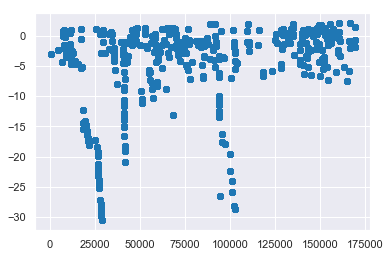

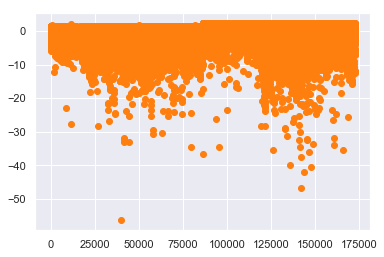

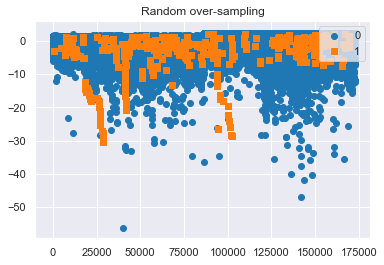

In [17]:
plt.scatter(
            X_ros[y_ros==1, 0],
            X_ros[y_ros==1, 1],
            c='#1F77B4', label=1, marker='o'
        )
plt.show()
plt.scatter(
            X_ros[y_ros==0, 0],
            X_ros[y_ros==0, 1],
            c='#FF7F0E', label=1, marker='o'
        )
plt.show()
plot_2d_space(X_ros, y_ros, 'Random over-sampling')

In [18]:
print (" Training Classification Report")
aDf = pd.DataFrame(columns=['Model', 'Class', 'precision', 'recall', 'f1-score', 'support'])
for x in classificationReportDict:
    aRow = {}
    aRow["Model"] = x
    for aClass in ['0', '1']:
        aRow["Class"] = aClass
        aRow.update(classificationReportDict[x][0][aClass])
        aDf = aDf.append(aRow, ignore_index=True)
print (aDf)
aDf.to_csv('trainClass.csv')
print ("-------------------------------------------------------------------")
print (" Test Classification Report")
aDf = pd.DataFrame(columns=['Model', 'Class', 'precision', 'recall', 'f1-score', 'support'])
for x in classificationReportDict:
    aRow = {}
    aRow["Model"] = x
    for aClass in ['0', '1']:
        aRow["Class"] = aClass
        aRow.update(classificationReportDict[x][1][aClass])
        aDf = aDf.append(aRow, ignore_index=True)
print (aDf)
aDf.to_csv('testClass.csv')

 Training Classification Report
                     Model Class  precision    recall  f1-score support
0              Initial Run     0   0.999380  0.999798  0.999589  227451
1              Initial Run     1   0.846154  0.642132  0.730159     394
2             DroppingTime     0   0.999385  0.999873  0.999629  227451
3             DroppingTime     1   0.897527  0.644670  0.750369     394
4               DroppingV1     0   0.999385  0.999798  0.999591  227451
..                     ...   ...        ...       ...       ...     ...
65     Random Oversampling     1   0.959222  0.889005  0.922780  227451
66  IMBLearn Undersampling     0   0.889930  0.964467  0.925700     394
67  IMBLearn Undersampling     1   0.961219  0.880711  0.919205     394
68   IMBLearn Oversampling     0   0.896268  0.962027  0.927984  227451
69   IMBLearn Oversampling     1   0.959020  0.888657  0.922499  227451

[70 rows x 6 columns]
-------------------------------------------------------------------
 Test Classif